<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

# AC SAF Level 3 - Workflow examples

The AC SAF Level 3 longterm monthly average data products are helpful to get a better overall picture of an atmospheric compostion parameter. Following workflows will help to get a better understanding of the behaviour of one specific parameter:
* <b>Visualization of global monthly aggregates</b><br>
    We can visualize the monthly aggregates on a `2D Map`
* <b>Visualization of a longterm trend for one specific location or region</b><br>
    We can generate a `time series plot` and visualize the longterm trend for one specific location. We can also compare two different locations and data values can also be spatially aggregated to visualize the global or regional longterm trend
* <b>the mean annual cycle for a parameter for one specific location or region</b><br>
    We can also aggregate in time and build the mean annual cycle for one location or region or globally
    
For all examples, we will make use of the `xarray` library. `xarray` offers useful functions and wrappers for the efficient handling of multi-dimensional data in `netCDF`.

<br>

This notebook contains examples for each of the Level 3 data products parameters. At the beginning, there is a section that loads required libraries, all the Level 3 data products as xarray `Datasets` and defines some functions that will be reused.

* [Nitrogen dioxide - Workflow example](#no2)
* [Tropospheric Ozone - Workflow example](#o3)
* [Total column water vapour - Workflow example](#wv)

<hr>

#### Load required libraries

In [212]:
import xarray as xr
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from ipyleaflet import Map
import cartopy.crs as ccrs


#### Load Level 3 data products as xarray `Datasets`

In [187]:
# Build list of time coordinates with pandas
time_coords = pd.date_range('2013-01', '2017-11', freq='MS').strftime("%Y-%m").astype('datetime64[ns]')
time_coords_o3 = pd.date_range('2013-01', '2019-06', freq='MS').strftime("%Y-%m").astype('datetime64[ns]')


##### Load NO<sub>2</sub> data products

In [191]:
no2_ds = xr.open_dataset('../sample_data/gome2b/level3/NO2/GOME_NO2_Global_201701_METOPB_DLR_v1.nc')
no2 = xr.open_mfdataset('../sample_data/gome2b/level3/NO2/*.nc', concat_dim='time',  group='PRODUCT')

no2_assigned = no2.assign_coords(latitude=ds.latitude, longitude=ds.longitude, time=time_coords)
no2_assigned

<xarray.Dataset>
Dimensions:          (latitude: 720, longitude: 1440, time: 59)
Coordinates:
  * latitude         (latitude) float32 -89.875 -89.625 ... 89.625 89.875
  * longitude        (longitude) float32 -179.875 -179.625 ... 179.625 179.875
  * time             (time) datetime64[ns] 2013-01-01 2013-02-01 ... 2017-11-01
Data variables:
    NO2total         (time, latitude, longitude) float32 dask.array<shape=(59, 720, 1440), chunksize=(1, 720, 1440)>
    NO2total_err     (time, latitude, longitude) float32 dask.array<shape=(59, 720, 1440), chunksize=(1, 720, 1440)>
    NO2total_stddev  (time, latitude, longitude) float32 dask.array<shape=(59, 720, 1440), chunksize=(1, 720, 1440)>
    NO2trop          (time, latitude, longitude) float32 dask.array<shape=(59, 720, 1440), chunksize=(1, 720, 1440)>
    NO2trop_err      (time, latitude, longitude) float32 dask.array<shape=(59, 720, 1440), chunksize=(1, 720, 1440)>
    NO2trop_stddev   (time, latitude, longitude) float32 dask.array<shap

##### Load O<sub>3</sub> data products

In [189]:
o3_ds = xr.open_dataset('../sample_data/gome2b/level3/O3tropo/GOME_O3tropo_Tropics_201301_METOPB_DLR_v1.nc')
o3 = xr.open_mfdataset('../sample_data/gome2b/level3/O3tropo/*.nc', concat_dim='time',  group='PRODUCT')

o3_assigned = o3.assign_coords(latitude=o3_ds.latitude, longitude=o3_ds.longitude, time=time_coords_o3)
o3_assigned

<xarray.Dataset>
Dimensions:                          (latitude: 32, longitude: 144, time: 78)
Coordinates:
  * latitude                         (latitude) float32 -19.375 ... 19.375
  * longitude                        (longitude) float32 -178.75 ... 178.75
  * time                             (time) datetime64[ns] 2013-01-01 ... 2019-06-01
Data variables:
    tropospheric_O3                  (time, latitude, longitude) float32 dask.array<shape=(78, 32, 144), chunksize=(1, 32, 144)>
    tropospheric_O3_std              (time, latitude, longitude) float32 dask.array<shape=(78, 32, 144), chunksize=(1, 32, 144)>
    tropospheric_O3_number           (time, latitude, longitude) float64 dask.array<shape=(78, 32, 144), chunksize=(1, 32, 144)>
    tropospheric_O3_mixingratio      (time, latitude, longitude) float32 dask.array<shape=(78, 32, 144), chunksize=(1, 32, 144)>
    tropospheric_O3_mixingratio_std  (time, latitude, longitude) float32 dask.array<shape=(78, 32, 144), chunksize=(1, 32, 1

##### Load H2O data products

In [190]:
wv_ds = xr.open_dataset('../sample_data/gome2b/level3/H20/GOME_H2O_Global_201301_METOPB_DLR_v1.nc')
wv = xr.open_mfdataset('../sample_data/gome2b/level3/H20/*.nc', concat_dim='time',  group='PRODUCT')

wv_assigned = wv.assign_coords(latitude=wv_ds.latitude, longitude=wv_ds.longitude, time=time_coords)
wv_assigned

<xarray.Dataset>
Dimensions:      (latitude: 360, longitude: 720, time: 59)
Coordinates:
  * latitude     (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude    (longitude) float32 -179.75 -179.25 -178.75 ... 179.25 179.75
  * time         (time) datetime64[ns] 2013-01-01 2013-02-01 ... 2017-11-01
Data variables:
    tcwv         (time, latitude, longitude) float32 dask.array<shape=(59, 360, 720), chunksize=(1, 360, 720)>
    tcwv_err     (time, latitude, longitude) float32 dask.array<shape=(59, 360, 720), chunksize=(1, 360, 720)>
    tcwv_stddev  (time, latitude, longitude) float32 dask.array<shape=(59, 360, 720), chunksize=(1, 360, 720)>
    nobs         (time, latitude, longitude) float32 dask.array<shape=(59, 360, 720), chunksize=(1, 360, 720)>

<hr>

#### Visualization functions

##### Visualize a `2D xarray DataArray` with `matplotlib` and `cartopy`

In [310]:
def visualize_map(array, timepos, projection, vmax, title, unit):
    fig=plt.figure(figsize=(20, 8))

    ax=plt.axes(projection=projection)
    ax.coastlines()
    ax.gridlines()
    ax.set_global()
    ax.set_title(title)

    plt.xticks(np.arange(-180, 180,60))
    plt.yticks(np.arange(-90,90,30))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    tmp = array[timepos,:,:]
    img1 = plt.imshow(tmp,
               extent=[array.longitude.min(),array.longitude.max(),array.latitude.max(),array.latitude.min()],
               cmap='gist_rainbow_r',
               aspect='auto',
               vmin=0,
               vmax=vmax)

    cb = fig.colorbar(img1)
    cb.set_label(unit, labelpad=5, y=0.5)
    plt.show()

<hr>

## <a id="no2"></a>Nitrogen dioxide - Workflow example

### 1) Explore data with a `2D Map`

A first step is to explore the data is to create a simple `2D Map`. We defined the function `visualize_map`, which takes the following kwargs:
* a xarray `DataArray`, 
* the index of the time axis (month-1 that shall be plotted),
* the projection,
* maximum data value to adjust the colorbar,
* a title for the plot, and
* the unit for the y-axis

You can explore different months by changing the number of the month.

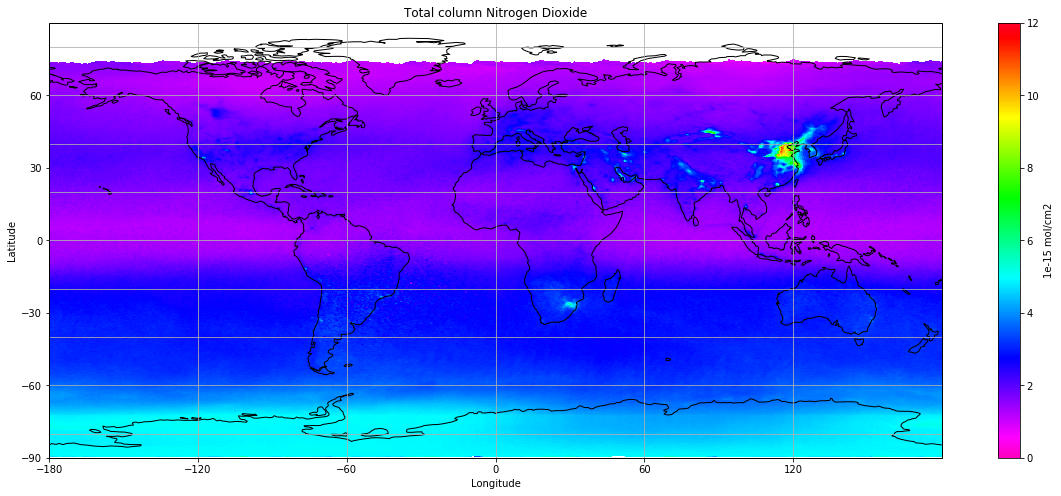

In [316]:
title='Total column Nitrogen Dioxide'
unit='1e-15 mol/cm2'
month = 10 # in Python iterations start at 0, thus 10 equals data values for month November

visualize_map(no2_assigned.NO2total*1e-15, month, ccrs.PlateCarree(), 12, title, unit)

<br>

### 2) Explore longterm trends of total column NO<sub>2</sub> for specific locations

The above map shows us that there is a prominent increase of the total column of nitrogen dioxide in the Beijing region. Let's have a look at the longterm trend for individual point locations.

xarray's label based selection method `sel` allows to select data based on name or value. `sel` further allows for enabling nearest neighbor, which select the closes e.g. latitude or longitude value. 

xarray offers a simple plotting wrapper of Python's matplotlib. Thus, we can directly apply the `plot` function to a `DataArray` object. We can add additional specifications, e.g. if it shall be a line plot, what color and style the line shall have, etc.

Let's plot the temporal trends for two locations: `Beijing` and `Darmstadt`, to see how much more the NO<sub>2</sub> levels in Beijing are elevated compared to a city in Germany. We specify latitude and longitude coordinates for both cities and plot the two DataArrays as line plots.

NOTE: the NO<sub>2</sub> values are shown in 1e<sup>-15</sup> molecules per cm<sup>2</sup>.

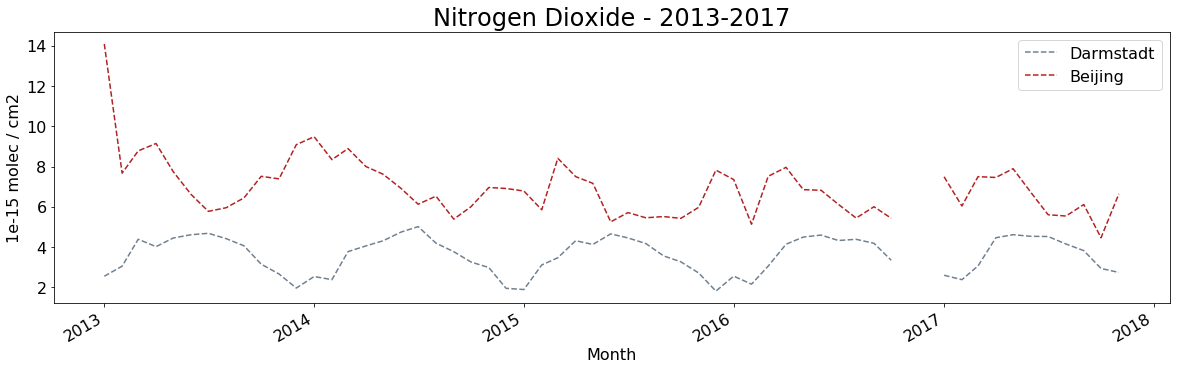

In [323]:
fig = plt.figure(figsize=(20,5))

# Latitude / Longitude coordinates for Darmstadt
city1 = 'Darmstadt'
lat1 = 49.875
lon1 = 8.650

# Latitude / Longitude coordinates for Beijing
city2 = 'Beijing'
lat2 = 39.908
lon2 = 116.397

city1_total = no2_assigned.NO2total.sel(latitude=lat1, longitude=lon1, method='nearest')*1e-15
city1_total.plot.line(color='slategrey', linestyle='dashed', label=city1)

city2_total = no2_assigned.NO2total.sel(latitude=lat2, longitude=lon2, method='nearest')*1e-15
city2_total.plot.line(linestyle='dashed',color='firebrick', label=city2)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Nitrogen Dioxide - 2013-2017", fontsize=24)
plt.ylabel('1e-15 molec / cm2', fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.legend(fontsize=16,loc=1)
plt.show()

<br>

The plot above shows that the NO<sub>2</sub> levels in Beijing are in general higher than the levels in Darmstadt. 

The NO<sub>2</sub> levels in Darmstadt follow a more or less regular annual cycle, with elevated values during summer and lower levels in winter. It seems that the NO<sub>2</sub> levels in Beijing follow an exact opposite cycle, with higher values during the winter months.

There is a prominent spike of NO<sub>2</sub> levels in Beijing in January 2013, which reflects the [Heavy haze pollution episode over central and western China](https://link.springer.com/article/10.1007/s11430-013-4773-4).

### 3) Compare total column NO<sub>2</sub> levels for specific locations with tropospheric NO<sub>2</sub> levels

The NO<sub>2</sub> `DataArray` holds total column and tropospheric nitrogen dioxide levels. We can add the tropospheric NO<sub>2</sub> levels for both cities, Beijing and Darmstadt, as barplots to the plot above. In this way, we can easily compare how troposhpheric NO<sub>2</sub> levels relate in comparison to total columns values.

We can add a barplot with matplotlib's `bar` function, which takes `np.datetime64` values as x and the tropospheric NO<sub>2</sub> values as y values.

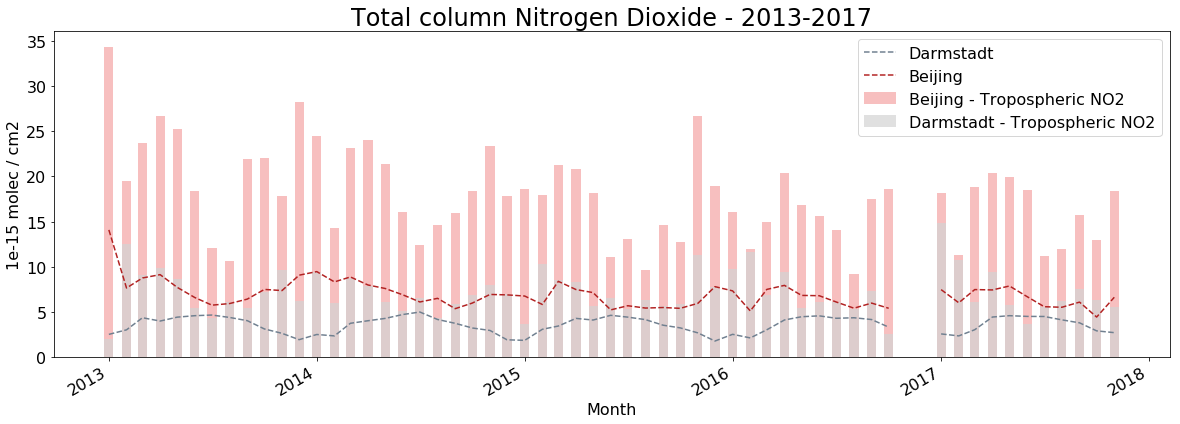

In [326]:
fig = plt.figure(figsize=(20,6))

darmstadt_total = no2_assigned.NO2total.sel(latitude=49.875, longitude=8.650, method='nearest')*1e-15
darmstadt_total.plot.line(color='slategrey', linestyle='dashed', label='Darmstadt')
beijing_total = no2_assigned.NO2total.sel(latitude=39.908, longitude=116.397, method='nearest')*1e-15
beijing_total.plot.line(linestyle='dashed',color='firebrick', label='Beijing')

darmstadt_tropo = no2_assigned.NO2trop.sel(latitude=49.875, longitude=8.650, method='nearest')*1e-15
beijing_tropo = no2_assigned.NO2trop.sel(latitude=39.908, longitude=116.397, method='nearest')*1e-15

bar_width=12
xticks = darmstadt_tropo.time.astype(np.datetime64)
plt.bar(xticks.values,beijing_tropo.values, align='center', alpha=0.5, width=16, color='lightcoral', label='Beijing - Tropospheric NO2')
plt.bar(xticks.values,darmstadt_tropo.values, align='center', alpha=0.7, width=16, color='lightgrey', label='Darmstadt - Tropospheric NO2')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Total column Nitrogen Dioxide - 2013-2017", fontsize=24)
plt.ylabel('1e-15 molec / cm2', fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.legend(fontsize=16,loc=1)
plt.show()

<br>

The plot above shows that the tropospheric NO<sub>2</sub> values are in general higher than the total column values. Here as well, the values of tropospheric NO<sub>2</sub> in Beijing exceed the ones in Darmstadt.

Interesting to see that it seems that the annual cycle of the tropospheric NO<sub>2</sub> in Darmstadt is opposite to the one of total column NO<sub>2</sub>. The tropospheric NO<sub>2</sub> levels are higher during winter time.

<hr>

## <a id="o3"></a>Tropospheric ozone - Workflow example

Tropopsheric ozone is a major air and climate pollutant. O<sub>3</sub> is known as a *secondary* pollutant because it is not emitted directly, but instead forms when precursor gases react in the presence of sunlight.  

Ozone (O3) is a reactive gas that exists in two layers of the atmosphere: the stratosphere (upper layer) and the troposphere (at ground level and up to 15km). In the stratosphere, ozone protects life on Earth from the sun’s ultraviolet radiation. In contrast, at lower levels, it is an important greenhouse gas and air pollutant, which is harmful to human and ecosystem health. It is also a major component of urban smog.

### 1) Explore data with a `2D Map`

A first step to explore the data is again creating a simple `2D Map` with the help of the function `visualize_map`.

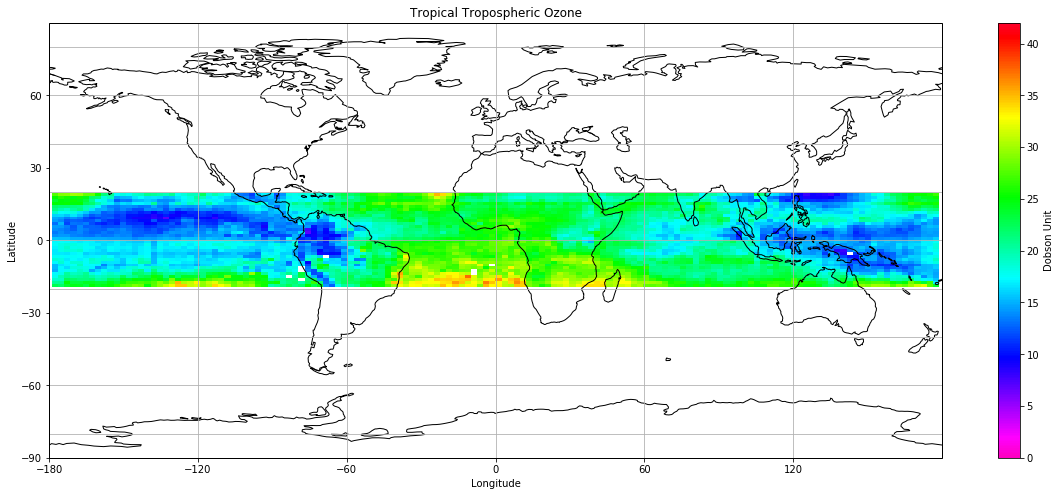

In [347]:
title='Tropical Tropospheric Ozone'
unit='Dobson Unit'

month = 10 # in Python iterations start at 0, thus 10 equals data values for month November

visualize_map(o3_assigned.tropospheric_O3, month, ccrs.PlateCarree(), 42,title, unit)

<br>

### 2) Calculate seasonal averages from the tropical tropospheric ozone timeseries of monthly means

In a second step, we can calculate the seasonal averages to get a better understanding of the tropospheric ozone levels throughout the year. The following example relies on the example that is provided as part of the [xarray documentation](http://xarray.pydata.org/en/stable/examples/monthly-means.html).

To do the calculation of seasonal averages properly, we have to calculate the weighted average as each month has a different number of days. The first, we define some functions (`leap_year` and `get_dpm`) that help us to determine the number of days in each month. We provide additional information of different calendar information.

#### Helper functions

In [394]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

<br>

#### Calculation of seasonal weighted averages

xarray offers helpful `groupby` and `reducer` functions in order to effectively aggregate data.<br>

The calculation of the seasonal weighted averages is a three step process:

1) Generate a DataArray with the number of days in each month <br>
2) Calculate the weights with the help of xarray's `groupby('time.season')` function <br>
3) Calculate the weighted average by multiplying the weights by the O<sub>3</sub> `DataArray` and sum along the time dimension.

In [412]:
# 1) Make a DataArray with the number of days in each month, size = len(time)
month_length = xr.DataArray(get_dpm(o3_assigned.time.to_index(), calendar='noleap'),
                            coords=[o3_assigned.time], name='month_length')

# 2) Calculate the weights by grouping by 'time.season'.
weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

# 3) Calculate the weighted average
o3_weighted = (o3_assigned * weights).groupby('time.season').sum(dim='time')
print(o3_weighted)

<xarray.Dataset>
Dimensions:                          (latitude: 32, longitude: 144, season: 4)
Coordinates:
  * latitude                         (latitude) float32 -19.375 ... 19.375
  * longitude                        (longitude) float32 -178.75 ... 178.75
  * season                           (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    tropospheric_O3                  (season, latitude, longitude) float64 dask.array<shape=(4, 32, 144), chunksize=(1, 32, 144)>
    tropospheric_O3_std              (season, latitude, longitude) float64 dask.array<shape=(4, 32, 144), chunksize=(1, 32, 144)>
    tropospheric_O3_number           (season, latitude, longitude) float64 dask.array<shape=(4, 32, 144), chunksize=(1, 32, 144)>
    tropospheric_O3_mixingratio      (season, latitude, longitude) float64 dask.array<shape=(4, 32, 144), chunksize=(1, 32, 144)>
    tropospheric_O3_mixingratio_std  (season, latitude, longitude) float64 dask.array<shape=(4, 32, 144), chunksize=(1, 32, 144

<br>

#### Plot the seasonal averages

In a final step, we can plot the weighted tropical tropospheric ozone information for each season with matplotlibs `subplots` function. 

We see that in season SON (months September, October, November) the tropospheric ozone levels are elevated compared to the other seasons.

<Figure size 432x288 with 0 Axes>

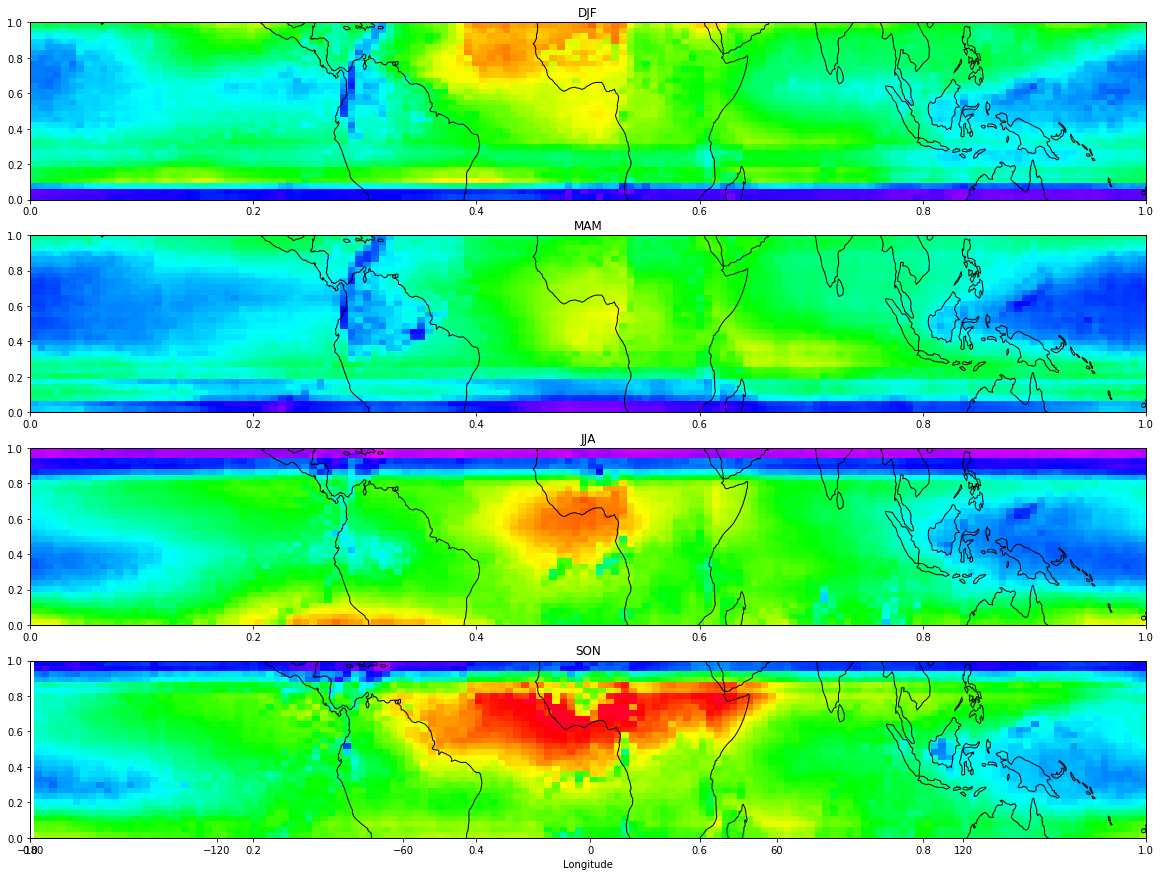

In [514]:
unit = 'Dobson Unit'
plt.figure()
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20,15))

ax1 = fig.add_subplot(411, projection=ccrs.PlateCarree())
tmp = o3_weighted['tropospheric_O3'].sel(season='DJF')
img1 = plt.imshow(tmp, vmin=0, vmax=35, cmap='gist_rainbow_r', aspect='auto', extent=[tmp.longitude.min(), tmp.longitude.max(), tmp.latitude.min(), tmp.latitude.max()])
ax1.coastlines()
ax1.set_title('DJF')

ax2 = fig.add_subplot(412,projection=ccrs.PlateCarree())
tmp = o3_weighted['tropospheric_O3'].sel(season='MAM')
img2 = plt.imshow(tmp, vmin=0, vmax=35, cmap='gist_rainbow_r', aspect='auto', extent=[tmp.longitude.min(), tmp.longitude.max(), tmp.latitude.min(), tmp.latitude.max()])
ax2.coastlines()
ax2.set_title('MAM')


ax3 = fig.add_subplot(413,projection=ccrs.PlateCarree())
tmp = o3_weighted['tropospheric_O3'].sel(season='JJA')
img3 = plt.imshow(tmp, vmin=0, vmax=35, cmap='gist_rainbow_r', aspect='auto', extent=[tmp.longitude.min(), tmp.longitude.max(), tmp.latitude.min(), tmp.latitude.max()])
ax3.coastlines()
ax3.set_title('JJA')


ax4 = fig.add_subplot(414,projection=ccrs.PlateCarree())
tmp = o3_weighted['tropospheric_O3'].sel(season='SON')
img4 = plt.imshow(tmp, vmin=0, vmax=35, cmap='gist_rainbow_r', aspect='auto', extent=[tmp.longitude.min(), tmp.longitude.max(), tmp.latitude.min(), tmp.latitude.max()])
ax4.coastlines()
ax4.set_title('SON')

plt.xticks(np.arange(-180, 180,60))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

<br>

### 3) Calculate the average annual cycle of tropical tropospheric Ozone levels

xarray's `groupby` function is very useful to implement `split-combine-apply` functionalities. With one line of code, we can calculate the average annual cycle of tropical tropospheric Ozone levels. In a second line of code, we can average over `latitude` and `longitude`, to create the mean annual cycle tropical tropospheric Ozone. 

The result is a `1D-vector` with mean values of tropical tropospheric O<sub>3</sub> levels. If we generate a `line` plot, we see that the lowest O<sub>3</sub> levels occur around May and elevate in the months September and October.

<br>

In [521]:
o3_annual_cycle = o3_assigned.groupby('time.month').mean('time')

o3_annual_cycle_average = o3_annual_cycle['tropospheric_O3'].mean(dim={'latitude', 'longitude'})
o3_annual_cycle_average


<xarray.DataArray 'tropospheric_O3' (month: 12)>
dask.array<shape=(12,), dtype=float32, chunksize=(1,)>
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

<br>

/Users/julia_wagemann/.virtualenvs/myvenv/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


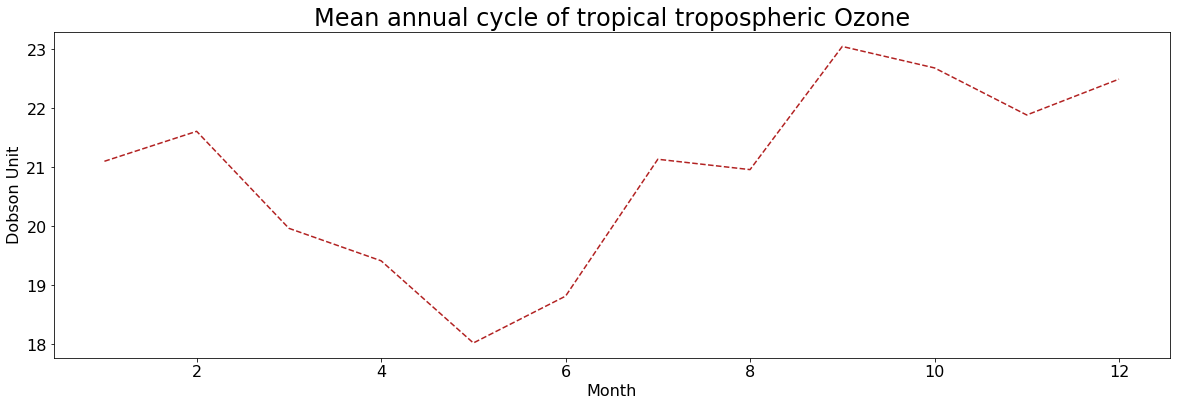

In [528]:
fig = plt.figure(figsize=(20,6))
o3_annual_cycle_average.plot.line(color='firebrick', linestyle='dashed')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Mean annual cycle of tropical tropospheric Ozone", fontsize=24)
plt.ylabel('Dobson Unit', fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.show()

<br>

<hr>

## <a id="wv"></a>Total column water vapour - Workflow example

### TODO

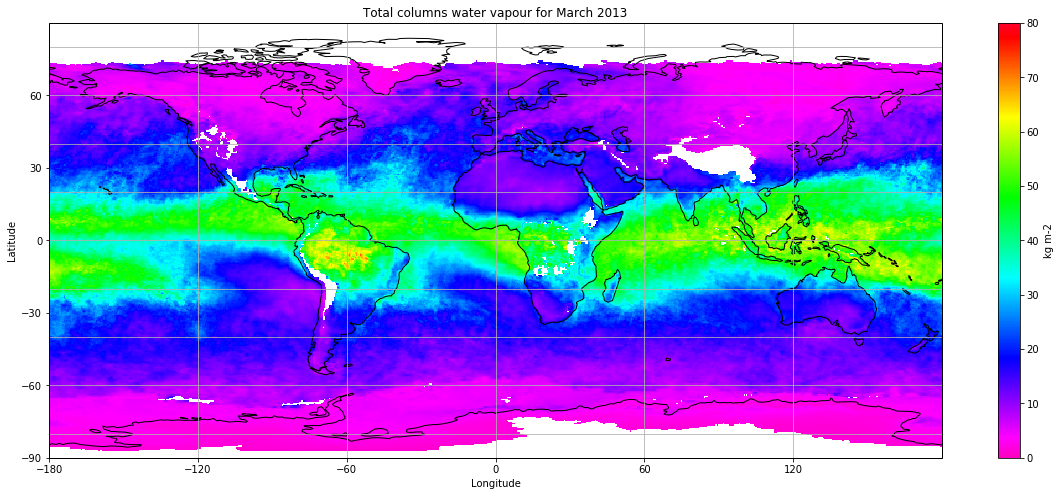

In [361]:
title='Total columns water vapour for March 2013'
unit='kg m-2'

visualize_map(wv_assigned.tcwv,10, ccrs.PlateCarree(), 80,title, unit)

<hr>

<p style="text-align:left;"><a href="https://gitlab.eumetsat.int/eo-lab/training-atmospheric-composition/blob/master/LICENSE">&copy; Copyright 2019 eo-lab</a> <span style="float:right;">View on GitLab | Cite | Contact</span></p>